<a href="https://colab.research.google.com/github/YaminMahdi/OralPredWeb/blob/master/histopathologic_oral_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Histopathologic Oral Cancer Detection and Quality Evaluation Using Image Analysis


## Table of contents:
* Import Libraries
* Read Data
* Visualization Of Dataset
* Data Augmentation
* VGG Model
* Evaluate The Model
##


# Import Libraries

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
tf.__version__


'2.15.0'

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                     📚 Students Performance Dataset 📚                    66KB  2024-06-12 23:09:20           5109        103  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024               Most Streamed Spotify Songs 2024                   496KB  2024-06-15 18:50:51           4087         92  1.0              
shreyanshverma27/online-sales-dataset-popular-marketplace-data  Online Sales Dataset - Popular Marketplace Data      7KB  2024-05-25 23:55:26          12194        218  1.0              
kanch

In [ ]:
!kaggle datasets download -d ashenafifasilkebede/dataset

Dataset URL: https://www.kaggle.com/datasets/ashenafifasilkebede/dataset
License(s): CC0-1.0
dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
replace test/Normal/Normal_100x_12.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
train_data_path = '/content/train'
test_data_path = '/content/test'
#valid_data_path = '/content/val'

# EDA

In [ ]:
data_dir = train_data_path
ds_name = 'Oral Cancer'

In [ ]:
# Generate data paths with labels

def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [ ]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [ ]:
df.head()


filepaths  labels
0      /content/train/Normal/aug_31_337.jpg  Normal
1    /content/train/Normal/aug_821_7650.jpg  Normal
2  /content/train/Normal/Normal_100x_51.jpg  Normal
3    /content/train/Normal/aug_130_1239.jpg  Normal
4    /content/train/Normal/aug_146_2121.jpg  Normal

In [ ]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

The Oral Cancer dataset has 4946 images.


In [ ]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")

num_of_classes(df, ds_name)

The Oral Cancer dataset has 2 classes


In [ ]:
def classes_count(df, name='df'):

    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)

classes_count(df, ds_name)

The Oral Cancer dataset has: 

Class 'Normal' has 2435 images
----------------------------------------------------------------------
Class 'OSCC' has 2511 images
----------------------------------------------------------------------


In [ ]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df,'labels')

In [ ]:
def check_null_values(df, name='df'):

    num_null_vals = sum(df.isnull().sum().values)

    if not num_null_vals:
        print(f"The {name} dataset has no null values")

    else:
        print(f"The {name} dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())


check_null_values(df, ds_name)

The Oral Cancer dataset has no null values


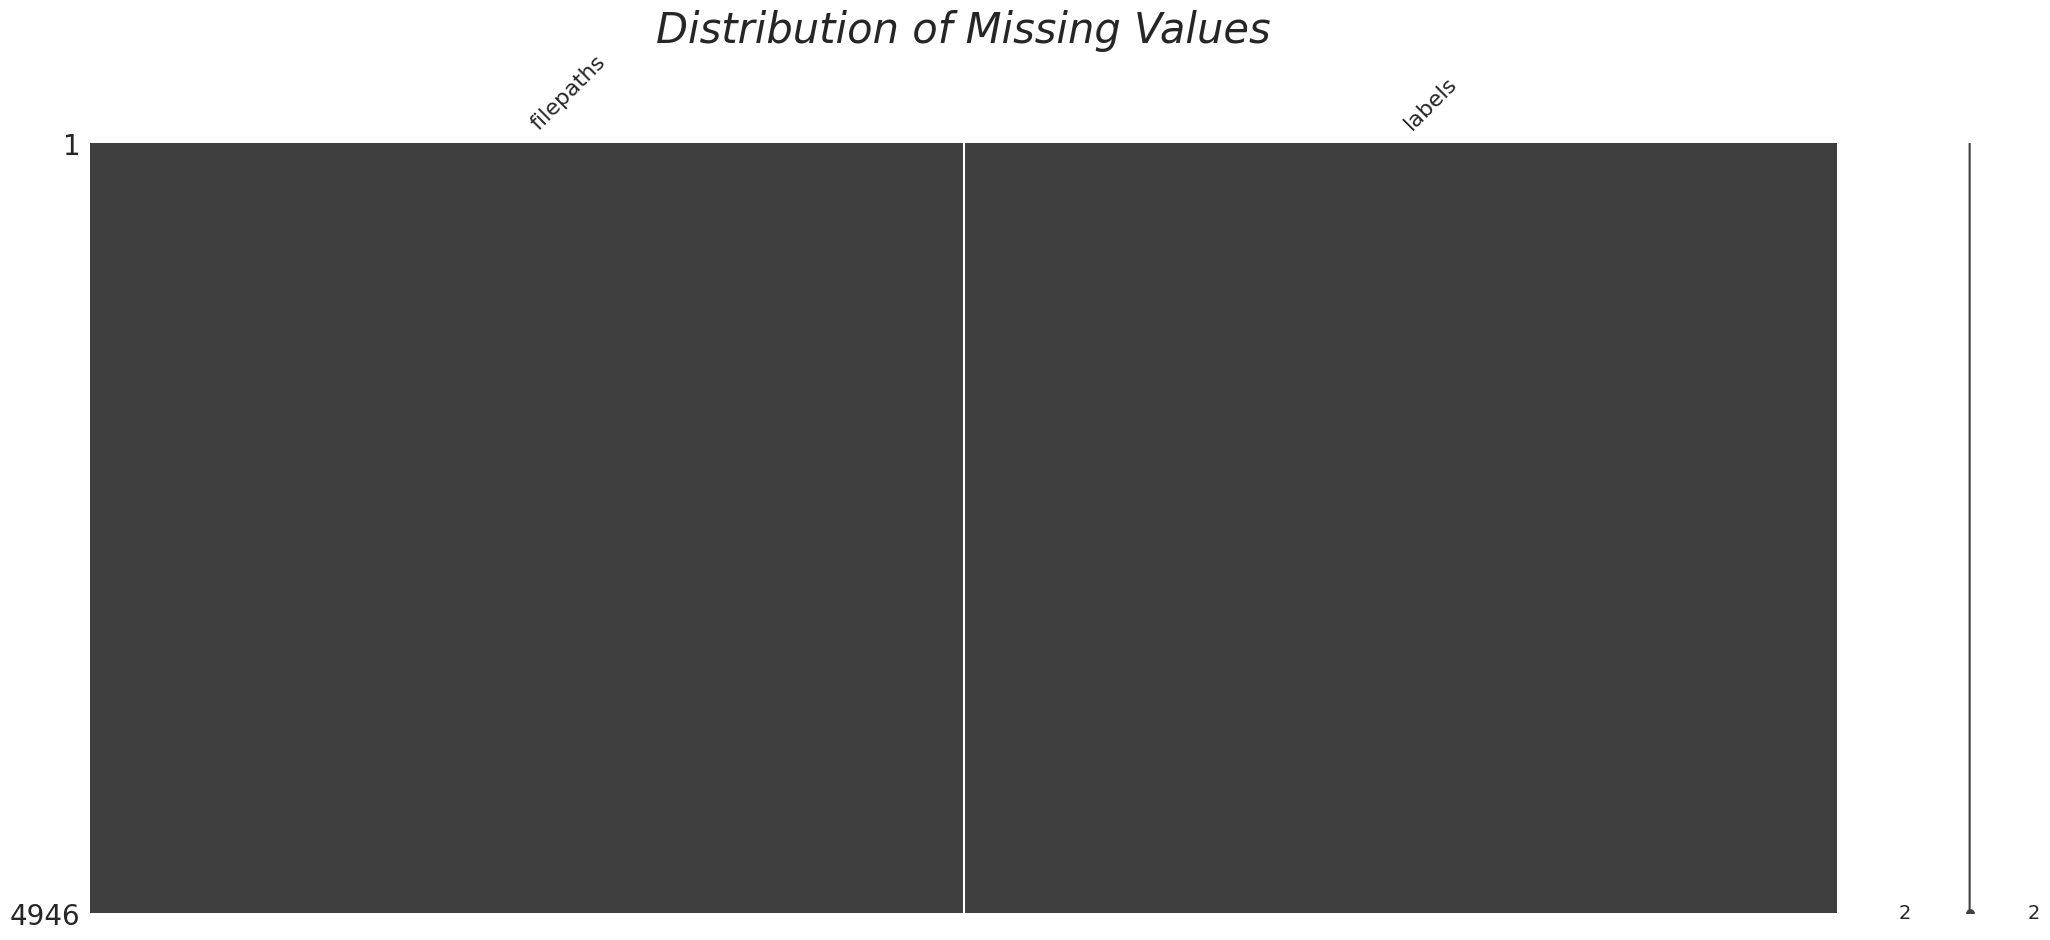

In [ ]:
msno.matrix(df)
plt.title('Distribution of Missing Values', fontsize=30, fontstyle='oblique');

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [ ]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Oral Cancer dataset has 2 classes
The Validation Oral Cancer dataset has 2 classes
The Testing Oral Cancer dataset has 2 classes


In [ ]:
classes_count(train_df, 'Training '+ds_name)


The Training Oral Cancer dataset has: 

Class 'Normal' has 1699 images
----------------------------------------------------------------------
Class 'OSCC' has 1763 images
----------------------------------------------------------------------


In [ ]:
classes_count(valid_df, 'Validation '+ds_name)


The Validation Oral Cancer dataset has: 

Class 'Normal' has 358 images
----------------------------------------------------------------------
Class 'OSCC' has 384 images
----------------------------------------------------------------------


In [ ]:
classes_count(test_df, 'Testing '+ds_name)


The Testing Oral Cancer dataset has: 

Class 'OSCC' has 364 images
----------------------------------------------------------------------
Class 'Normal' has 378 images
----------------------------------------------------------------------


In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           horizontal_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 3462 validated image filenames belonging to 2 classes.
Found 742 validated image filenames belonging to 2 classes.
Found 742 validated image filenames belonging to 2 classes.


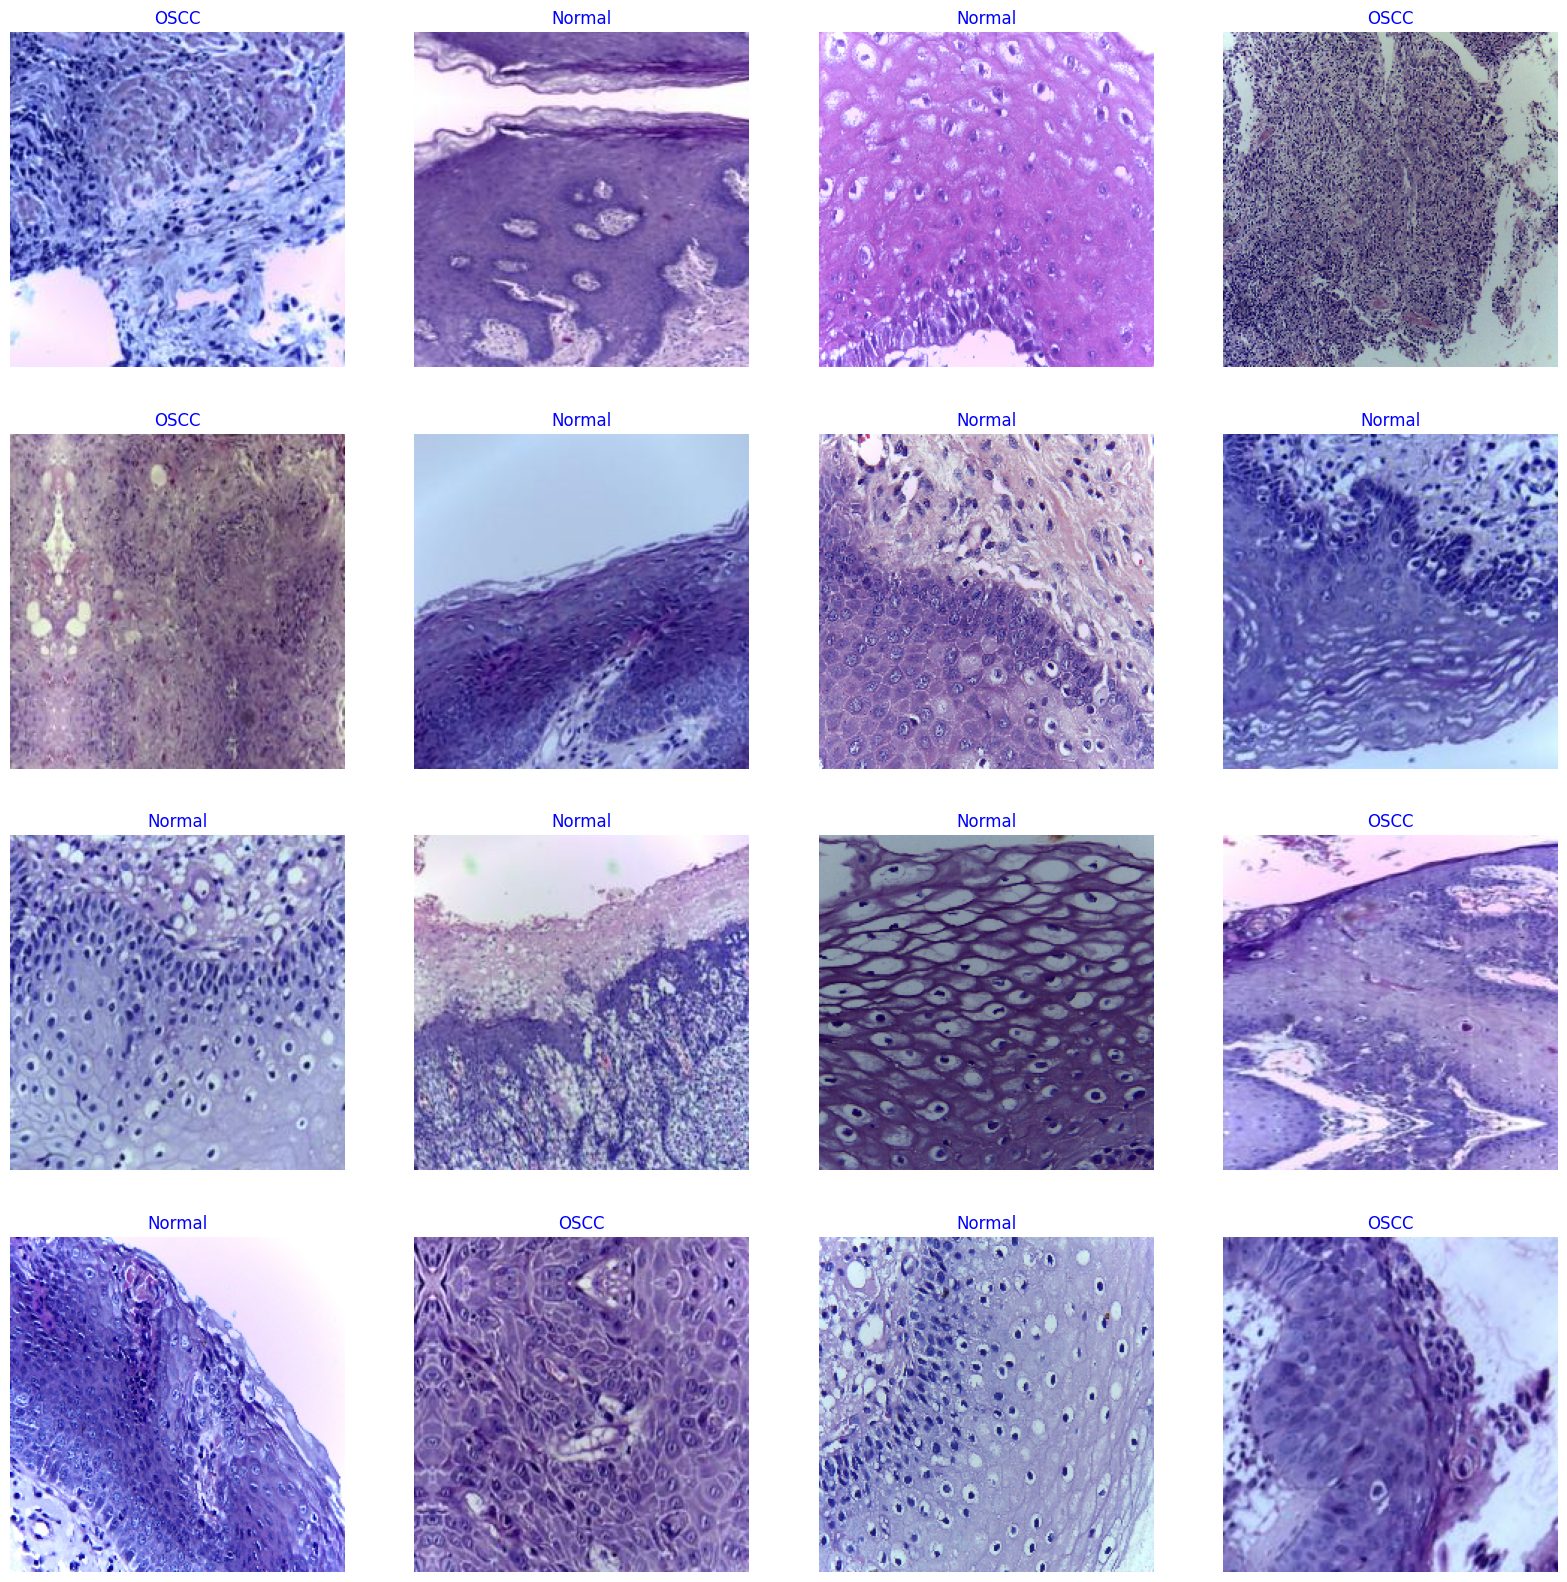

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):

    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

# Model structure

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

efficentNet_model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
      bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate= 0.3, seed= 123),
    Dense(class_count, activation= 'softmax')
])

efficentNet_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

efficentNet_model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                         

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               mode='min',
                              )

In [ ]:
batch_size = 32   # set batch size for training
epochs = 5   # number of all epochs in training

history = efficentNet_model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen,
                    validation_steps= None,
                    shuffle= False,
                    batch_size= batch_size)

Epoch 1/5
217/217 [==============================] - 1932s 9s/step - loss: 6.0348 - accuracy: 0.7868 - val_loss: 4.2004 - val_accuracy: 0.9124
Epoch 2/5
217/217 [==============================] - 1846s 9s/step - loss: 3.2424 - accuracy: 0.9200 - val_loss: 2.4493 - val_accuracy: 0.9528
Epoch 3/5
217/217 [==============================] - 1841s 8s/step - loss: 1.9324 - accuracy: 0.9529 - val_loss: 1.5201 - val_accuracy: 0.9623
Epoch 4/5
217/217 [==============================] - 1847s 9s/step - loss: 1.2200 - accuracy: 0.9653 - val_loss: 0.9716 - val_accuracy: 0.9704
Epoch 5/5
217/217 [==============================] - 1841s 8s/step - loss: 0.7881 - accuracy: 0.9708 - val_loss: 0.6479 - val_accuracy: 0.9717


# Model Evaluate and prediction

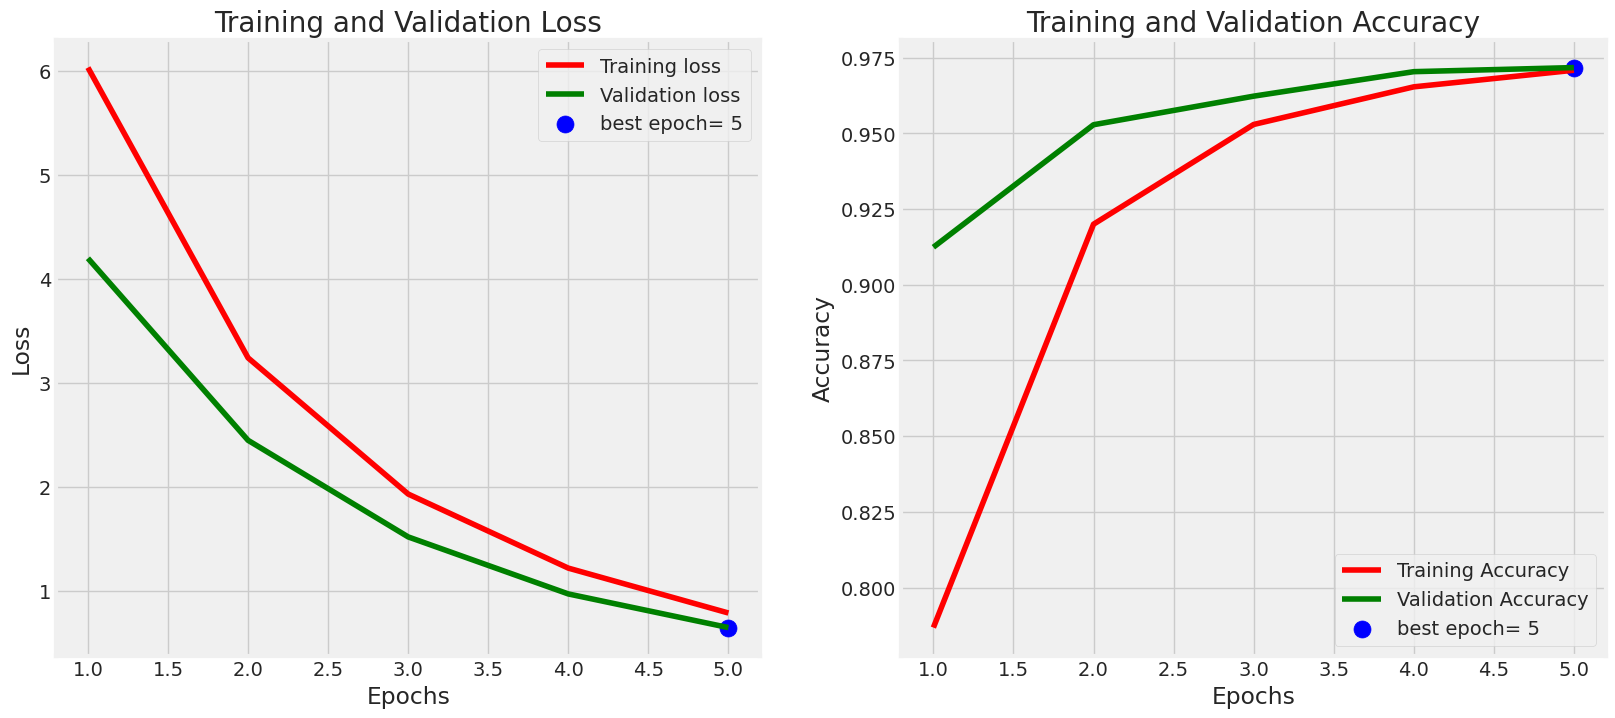

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = efficentNet_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = efficentNet_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = efficentNet_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

14/14 [==============================] - 109s 7s/step - loss: 0.6246 - accuracy: 0.9784
Train Loss:  0.5778440833091736
Train Accuracy:  0.9955357313156128
--------------------
Validation Loss:  0.6393378973007202
Validation Accuracy:  0.9776785969734192
--------------------
Test Loss:  0.6245522499084473
Test Accuracy:  0.9784366488456726


In [ ]:
preds = efficentNet_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

14/14 [==============================] - 107s 7s/step


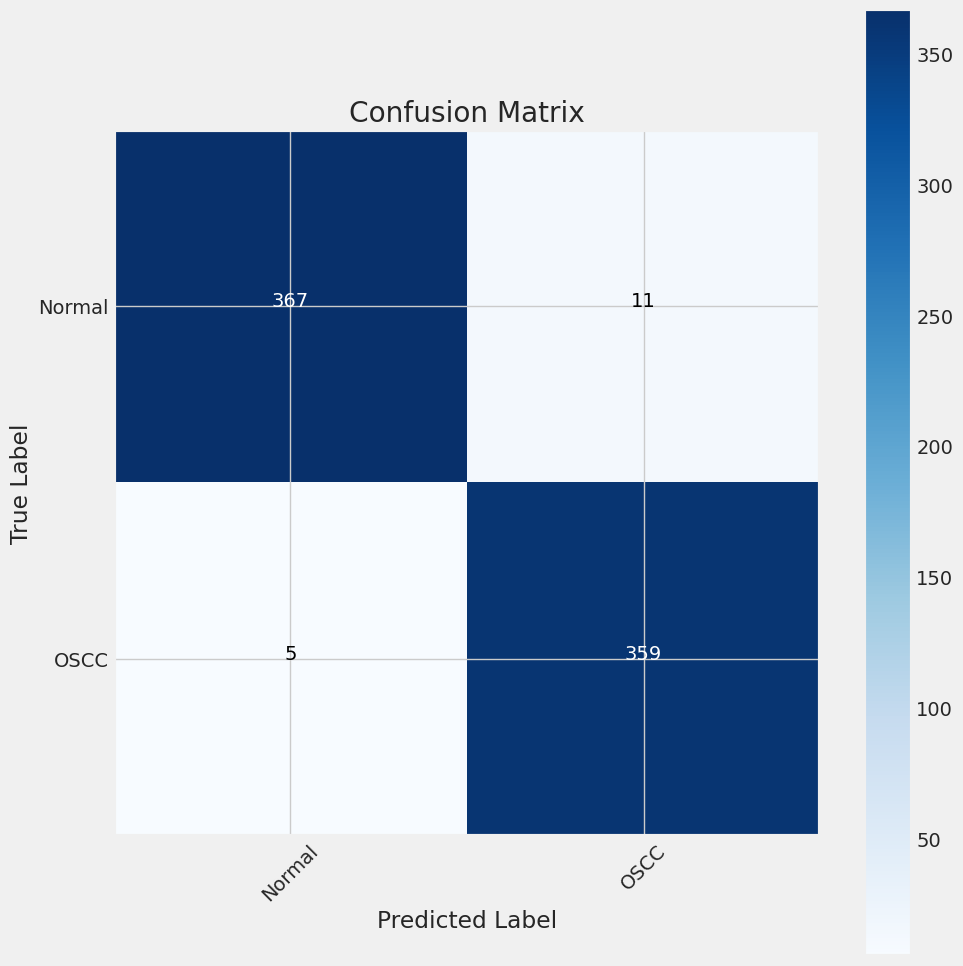

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       378
        OSCC       0.97      0.99      0.98       364

    accuracy                           0.98       742
   macro avg       0.98      0.98      0.98       742
weighted avg       0.98      0.98      0.98       742



# save our model and test it

In [ ]:
efficentNet_model.save('oral-efficientNet.h5')

1/1 [==============================] - 3s 3s/step


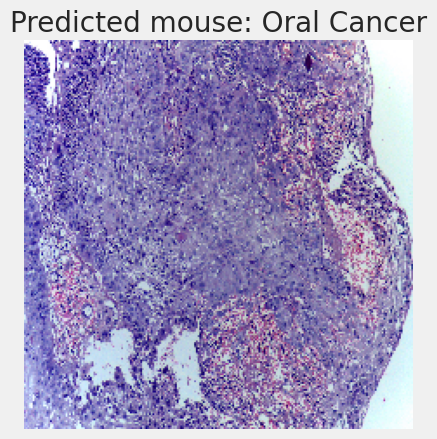

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted mouse: {predicted_class_label}")
    plt.show()

# Load your trained model
efficentNet_model.load_weights('/content/oral-efficientNet.h5')

# Define your class labels (e.g., ['car', 'truck', ...])
class_labels = ['Normal', 'Oral Cancer']

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = '/content/test/OSCC/OSCC_100x_199.jpg'
predict_and_display(image_path_to_test, efficentNet_model, class_labels)

1/1 [==============================] - 0s 162ms/step


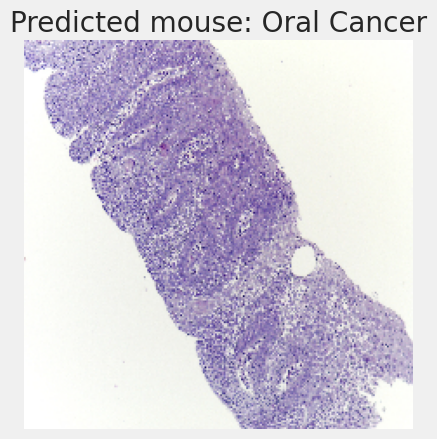

In [ ]:
image_path_to_test = '/content/test/OSCC/OSCC_100x_2.jpg'
predict_and_display(image_path_to_test, efficentNet_model, class_labels)

1/1 [==============================] - 0s 162ms/step


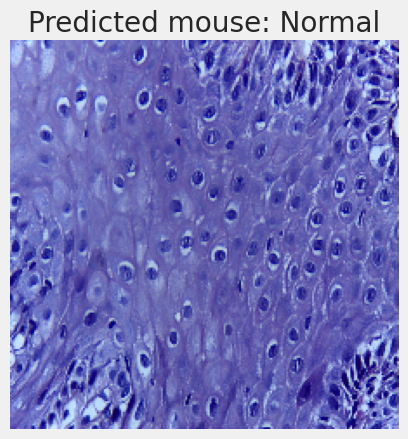

In [ ]:
image_path_to_test = '/content/test/Normal/Normal_400x_152.jpg'
predict_and_display(image_path_to_test, efficentNet_model, class_labels)